#Ai-Detector with ResNet101

##Import

In [1]:
import matplotlib
import numpy
import PIL
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader


import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report


#import timm

In [2]:
from google.colab import files
files.upload()

Saving SRM_Kernels.npy to SRM_Kernels.npy


{'SRM_Kernels.npy': b"\x93NUMPY\x01\x00F\x00{'descr': '<f4', 'fortran_order': False, 'shape': (5, 5, 1, 30), }   \n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbf\x00\x00\x80\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

###Kaggle setup

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gianlucadenardi88","key":"66594de2b116d15ad1227fba6c46b865"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d rafsunahmad/camera-photos-vs-ai-generated-photos-classifier


Dataset URL: https://www.kaggle.com/datasets/rafsunahmad/camera-photos-vs-ai-generated-photos-classifier
License(s): U.S. Government Works
100% 191M/192M [00:11<00:00, 21.8MB/s]
100% 192M/192M [00:11<00:00, 16.8MB/s]


#Dati

In [6]:
#2
import zipfile
import os

zip_file_path = '/content/camera-photos-vs-ai-generated-photos-classifier'
unzip_folder_path = '/content/data'

# Create the destination folder if it doesn't exist
os.makedirs(unzip_folder_path, exist_ok=True)

!unzip -q {zip_file_path} -d {unzip_folder_path}

# Verify the result
print("Contents of the unzipped folder:")
print(os.listdir(unzip_folder_path))

Contents of the unzipped folder:
['ai vs real photos']


##Dati di addestramento e di test:

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])
# Imposta il percorso della directory del dataset
dataset_dir = '/content/data/ai_vs_real_photos'

# Creare il dataset usando ImageFolder
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Suddividere il dataset in training e test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])



##DataLoader

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

##Verifica struttura

In [9]:
print(f"Classi del dataset: {dataset.classes}")
print(f"Etichette delle classi: {dataset.class_to_idx}")

Classi del dataset: ['Ai_Images', 'Camera_images']
Etichette delle classi: {'Ai_Images': 0, 'Camera_images': 1}


#FingerPrint

##Funzioni di supporto

In [10]:
def texture_diversity(patch):
    grayscale_patch = torch.mean(patch, dim=0)
    gradients = [
        torch.abs(grayscale_patch[:-1, :-1] - grayscale_patch[1:, 1:]),
        torch.abs(grayscale_patch[:-1, 1:] - grayscale_patch[1:, :-1]),
        torch.abs(grayscale_patch[:, :-1] - grayscale_patch[:, 1:]),
        torch.abs(grayscale_patch[:-1, :] - grayscale_patch[1:, :])
    ]
    diversity = sum(torch.sum(grad) for grad in gradients)
    return diversity.item()

def break_into_patches(image, patch_size):
    _, height, width = image.shape
    num_patches_height = height // patch_size
    num_patches_width = width // patch_size
    patches = []
    for i in range(num_patches_height):
        for j in range(num_patches_width):
            patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patches.append(patch)
    return patches

def get_rich_and_poor_patches(img_tensor, patch_size):
    patches = break_into_patches(img_tensor, patch_size)
    diversity = {i: texture_diversity(patch) for (i, patch) in enumerate(patches)}
    sorted_diversity = sorted(diversity.items(), key=lambda item: item[1])
    num_patches = len(patches)
    poor_patches_idx = [k for k, _ in sorted_diversity[:64]]
    rich_patches_idx = [k for k, _ in sorted_diversity[-64:]]
    poor_patches = [patches[i] for i in poor_patches_idx]
    rich_patches = [patches[j] for j in rich_patches_idx]
    return rich_patches, poor_patches

def combine_patches_into_image(patches, patch_size):
    num_patches = len(patches)
    side_length = int(num_patches**0.5)
    image_tensor = torch.zeros(3, side_length * patch_size, side_length * patch_size)
    for idx, patch in enumerate(patches):
        i = idx // side_length
        j = idx % side_length
        image_tensor[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch
    return image_tensor

def get_rich_and_poor_images(img_tensor, patch_size):
    rich_patches, poor_patches = get_rich_and_poor_patches(img_tensor, patch_size)
    rich_image_tensor = combine_patches_into_image(rich_patches, patch_size)
    poor_image_tensor = combine_patches_into_image(poor_patches, patch_size)
    return rich_image_tensor, poor_image_tensor


##Modello

In [11]:
class FingerPrint(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.kernels = self.load_high_pass_filters()
        self.conv_block = nn.Sequential(
            nn.Conv2d(30, 3, (5, 5)),
            nn.BatchNorm2d(3),
            nn.Hardtanh()
        )

    def forward(self, rich_patch, poor_patch):
        device = rich_patch.device
        self.kernels = self.kernels.to(device)

        # Pass into highpass filters
        rich_filtered = F.conv2d(rich_patch, self.kernels)
        poor_filtered = F.conv2d(poor_patch, self.kernels)

        # Get rich and poor texture images
        out_rich = self.conv_block(rich_filtered)
        out_poor = self.conv_block(poor_filtered)

        # Get fingerprint image
        fingerprint = torch.sub(out_poor, out_rich)

        # Ensure the fingerprint has 3 channels
        if fingerprint.shape[1] == 1:
            fingerprint = fingerprint.repeat(1, 3, 1, 1)

        return fingerprint

    def load_high_pass_filters(self):
        kernels = np.load('/content/SRM_Kernels.npy')
        filters = np.tile(kernels, (1, 1, 3, 1))
        filters_tensors = [torch.tensor(f, dtype=torch.float32).permute(2, 0, 1) for f in np.moveaxis(filters, -1, 0)]
        return torch.stack(filters_tensors)

fingerprint_model = FingerPrint()


##Verifica delle immagini fingerprint

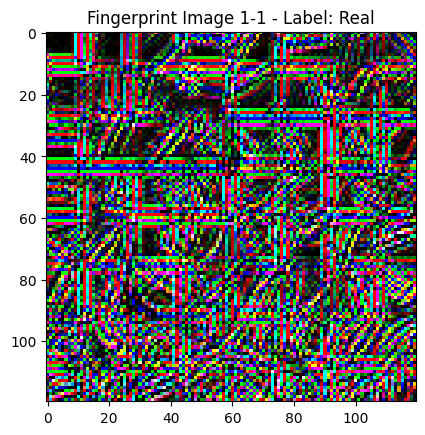

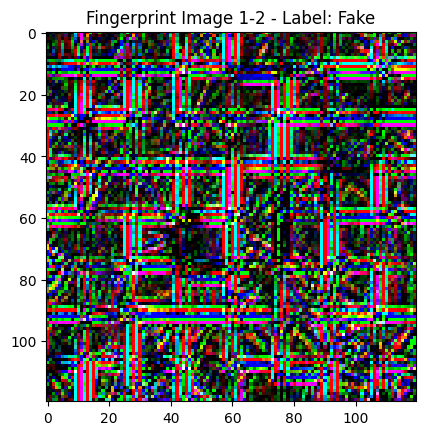

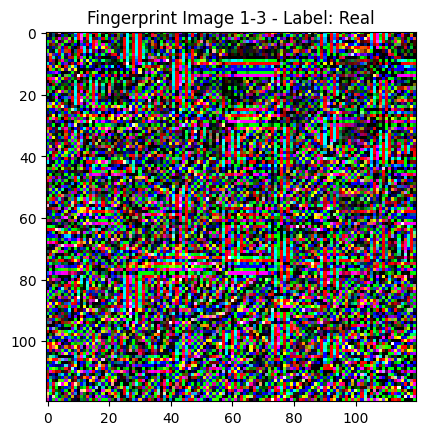

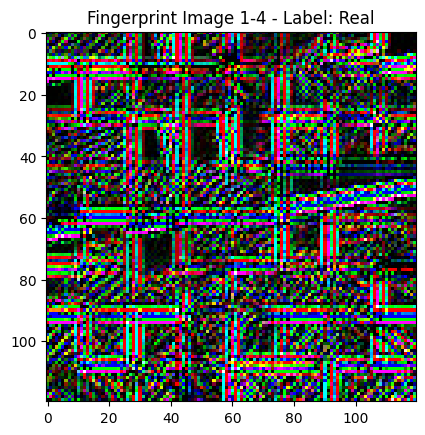

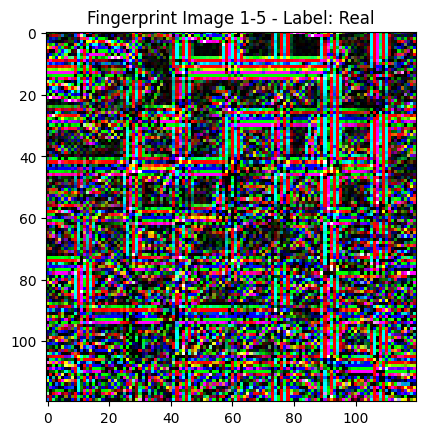

In [14]:
patch_size = 16

for i, (images, labels) in enumerate(train_loader):
    for j in range(images.size(0)):  # Iterare su ciascuna immagine nel batch
        image = images[j]
        label = labels[j]

        rich_image, poor_image = get_rich_and_poor_images(image, patch_size=patch_size)
        fingerprint_image = fingerprint_model(rich_image.unsqueeze(0), poor_image.unsqueeze(0)).squeeze(0)
        if i < 1 and j < 5:
            plt.figure()
            plt.title(f'Fingerprint Image {i+1}-{j+1} - Label: {"Fake" if label == 0 else "Real"}')
            plt.imshow(fingerprint_image.permute(1, 2, 0).detach().cpu().numpy())
            plt.show()
    if i == 0:
        break

#Classificatore

##ResNet101

In [15]:
class ResNet101Classifier(nn.Module):
    def __init__(self):
        super(ResNet101Classifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet101Classifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


##Preparazione Dataloader per immagini FingerPrint patch_size =16

In [16]:
class FingerprintDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, fingerprint_model, patch_size=16, transform=None):
        self.dataset = dataset
        self.fingerprint_model = fingerprint_model
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # Check if image is already a tensor, if not apply transform
        if not isinstance(image, torch.Tensor) and self.transform:
            image = self.transform(image)
        rich_image, poor_image = get_rich_and_poor_images(image, self.patch_size)
        fingerprint_image = self.fingerprint_model(rich_image.unsqueeze(0), poor_image.unsqueeze(0)).squeeze(0)
        return fingerprint_image, label

train_fingerprint_dataset = FingerprintDataset(train_dataset, fingerprint_model, transform=transform)
test_fingerprint_dataset = FingerprintDataset(test_dataset, fingerprint_model, transform=transform)

train_fingerprint_loader = DataLoader(train_fingerprint_dataset, batch_size=16, shuffle=True)
test_fingerprint_loader = DataLoader(test_fingerprint_dataset, batch_size=16, shuffle=False)


###Caricamento modello salvato

In [ ]:
'''model = ResNet101Classifier().to(device)
model.load_state_dict(torch.load('resnet50_fingerprint_model.pth'))
model.eval()'''

#Addestramento

In [17]:
num_epochs = 100
save_interval = 10

for epoch in range(num_epochs):
    start_time = time.time()  # Inizia il timer per l'epoca
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_fingerprint_loader), total=len(train_fingerprint_loader))
    for i, data in progress_bar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # Convert labels to float and add extra dimension for BCELoss
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Aggiornamento della barra di progresso
        progress_bar.set_description(f'[Epoch {epoch + 1}] Loss: {running_loss / (i + 1):.3f}')
    scheduler.step()  # Aggiornamento del learning rate

    # Validazione
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_fingerprint_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Convert labels to float and add extra dimension for BCELoss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs > 0.5  # Predizioni binarie
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_accuracy = 100 * correct / total
    end_time = time.time()  # Fine del timer per l'epoca
    epoch_duration = end_time - start_time

    print(f'Epoch {epoch + 1} - Training loss: {running_loss / len(train_fingerprint_loader):.3f}, Validation loss: {val_loss / len(test_fingerprint_loader):.3f}, Validation Accuracy: {val_accuracy:.2f}%, Time: {epoch_duration:.2f}s')

    # Salvataggio del modello ogni 10 epoche
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), f'modelRNN_epoch_{epoch + 1}.pth')

print('Finished Training')


[Epoch 1] Loss: 0.832: 100%|██████████| 23/23 [00:38<00:00,  1.69s/it]


Epoch 1 - Training loss: 0.832, Validation loss: 1.476, Validation Accuracy: 46.15%, Time: 47.53s


[Epoch 2] Loss: 0.733: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Epoch 2 - Training loss: 0.733, Validation loss: 0.709, Validation Accuracy: 50.55%, Time: 45.58s


[Epoch 3] Loss: 0.659: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 3 - Training loss: 0.659, Validation loss: 0.601, Validation Accuracy: 63.74%, Time: 45.24s


[Epoch 4] Loss: 0.645: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 4 - Training loss: 0.645, Validation loss: 0.653, Validation Accuracy: 59.34%, Time: 44.95s


[Epoch 5] Loss: 0.606: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Epoch 5 - Training loss: 0.606, Validation loss: 0.657, Validation Accuracy: 63.74%, Time: 45.49s


[Epoch 6] Loss: 0.609: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 6 - Training loss: 0.609, Validation loss: 0.946, Validation Accuracy: 59.34%, Time: 44.68s


[Epoch 7] Loss: 0.621: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Epoch 7 - Training loss: 0.621, Validation loss: 0.656, Validation Accuracy: 62.64%, Time: 45.39s


[Epoch 8] Loss: 0.558: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 8 - Training loss: 0.558, Validation loss: 0.616, Validation Accuracy: 62.64%, Time: 44.63s


[Epoch 9] Loss: 0.623: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 9 - Training loss: 0.623, Validation loss: 0.586, Validation Accuracy: 72.53%, Time: 45.12s


[Epoch 10] Loss: 0.583: 100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Epoch 10 - Training loss: 0.583, Validation loss: 0.917, Validation Accuracy: 63.74%, Time: 44.09s


[Epoch 11] Loss: 0.548: 100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Epoch 11 - Training loss: 0.548, Validation loss: 0.611, Validation Accuracy: 69.23%, Time: 44.91s


[Epoch 12] Loss: 0.582: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 12 - Training loss: 0.582, Validation loss: 0.569, Validation Accuracy: 72.53%, Time: 48.99s


[Epoch 13] Loss: 0.532: 100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 13 - Training loss: 0.532, Validation loss: 0.554, Validation Accuracy: 71.43%, Time: 45.13s


[Epoch 14] Loss: 0.551: 100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Epoch 14 - Training loss: 0.551, Validation loss: 0.534, Validation Accuracy: 76.92%, Time: 44.70s


[Epoch 15] Loss: 0.512: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 15 - Training loss: 0.512, Validation loss: 0.523, Validation Accuracy: 74.73%, Time: 45.35s


[Epoch 16] Loss: 0.512: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Epoch 16 - Training loss: 0.512, Validation loss: 0.540, Validation Accuracy: 73.63%, Time: 44.82s


[Epoch 17] Loss: 0.526: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 17 - Training loss: 0.526, Validation loss: 0.611, Validation Accuracy: 67.03%, Time: 45.90s


[Epoch 18] Loss: 0.510: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 18 - Training loss: 0.510, Validation loss: 0.591, Validation Accuracy: 70.33%, Time: 44.81s


[Epoch 19] Loss: 0.483: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 19 - Training loss: 0.483, Validation loss: 0.565, Validation Accuracy: 72.53%, Time: 45.71s


[Epoch 20] Loss: 0.514: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 20 - Training loss: 0.514, Validation loss: 0.522, Validation Accuracy: 73.63%, Time: 45.75s


[Epoch 21] Loss: 0.496: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 21 - Training loss: 0.496, Validation loss: 0.530, Validation Accuracy: 78.02%, Time: 44.92s


[Epoch 22] Loss: 0.463: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 22 - Training loss: 0.463, Validation loss: 0.545, Validation Accuracy: 72.53%, Time: 45.78s


[Epoch 23] Loss: 0.504: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 23 - Training loss: 0.504, Validation loss: 0.557, Validation Accuracy: 70.33%, Time: 45.02s


[Epoch 24] Loss: 0.507: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Epoch 24 - Training loss: 0.507, Validation loss: 0.550, Validation Accuracy: 70.33%, Time: 45.56s


[Epoch 25] Loss: 0.494: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 25 - Training loss: 0.494, Validation loss: 0.553, Validation Accuracy: 74.73%, Time: 45.91s


[Epoch 26] Loss: 0.511: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 26 - Training loss: 0.511, Validation loss: 0.591, Validation Accuracy: 68.13%, Time: 45.55s


[Epoch 27] Loss: 0.489: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 27 - Training loss: 0.489, Validation loss: 0.528, Validation Accuracy: 70.33%, Time: 45.90s


[Epoch 28] Loss: 0.449: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 28 - Training loss: 0.449, Validation loss: 0.560, Validation Accuracy: 71.43%, Time: 45.72s


[Epoch 29] Loss: 0.465: 100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Epoch 29 - Training loss: 0.465, Validation loss: 0.573, Validation Accuracy: 71.43%, Time: 44.17s


[Epoch 30] Loss: 0.497: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 30 - Training loss: 0.497, Validation loss: 0.545, Validation Accuracy: 76.92%, Time: 45.76s


[Epoch 31] Loss: 0.503: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 31 - Training loss: 0.503, Validation loss: 0.489, Validation Accuracy: 76.92%, Time: 44.75s


[Epoch 32] Loss: 0.492: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 32 - Training loss: 0.492, Validation loss: 0.603, Validation Accuracy: 69.23%, Time: 45.95s


[Epoch 33] Loss: 0.486: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 33 - Training loss: 0.486, Validation loss: 0.640, Validation Accuracy: 65.93%, Time: 45.65s


[Epoch 34] Loss: 0.485: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 34 - Training loss: 0.485, Validation loss: 0.615, Validation Accuracy: 69.23%, Time: 44.85s


[Epoch 35] Loss: 0.481: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 35 - Training loss: 0.481, Validation loss: 0.513, Validation Accuracy: 74.73%, Time: 45.88s


[Epoch 36] Loss: 0.479: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 36 - Training loss: 0.479, Validation loss: 0.517, Validation Accuracy: 74.73%, Time: 44.78s


[Epoch 37] Loss: 0.462: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 37 - Training loss: 0.462, Validation loss: 0.550, Validation Accuracy: 67.03%, Time: 45.63s


[Epoch 38] Loss: 0.485: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 38 - Training loss: 0.485, Validation loss: 0.601, Validation Accuracy: 68.13%, Time: 45.15s


[Epoch 39] Loss: 0.468: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 39 - Training loss: 0.468, Validation loss: 0.593, Validation Accuracy: 71.43%, Time: 45.66s


[Epoch 40] Loss: 0.499: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 40 - Training loss: 0.499, Validation loss: 0.532, Validation Accuracy: 72.53%, Time: 45.39s


[Epoch 41] Loss: 0.494: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 41 - Training loss: 0.494, Validation loss: 0.534, Validation Accuracy: 76.92%, Time: 44.88s


[Epoch 42] Loss: 0.480: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 42 - Training loss: 0.480, Validation loss: 0.532, Validation Accuracy: 71.43%, Time: 45.42s


[Epoch 43] Loss: 0.459: 100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Epoch 43 - Training loss: 0.459, Validation loss: 0.547, Validation Accuracy: 73.63%, Time: 44.00s


[Epoch 44] Loss: 0.476: 100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Epoch 44 - Training loss: 0.476, Validation loss: 0.565, Validation Accuracy: 68.13%, Time: 44.21s


[Epoch 45] Loss: 0.467: 100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Epoch 45 - Training loss: 0.467, Validation loss: 0.523, Validation Accuracy: 75.82%, Time: 43.83s


[Epoch 46] Loss: 0.495: 100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Epoch 46 - Training loss: 0.495, Validation loss: 0.578, Validation Accuracy: 69.23%, Time: 44.55s


[Epoch 47] Loss: 0.468: 100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


Epoch 47 - Training loss: 0.468, Validation loss: 0.509, Validation Accuracy: 73.63%, Time: 47.00s


[Epoch 48] Loss: 0.514: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 48 - Training loss: 0.514, Validation loss: 0.470, Validation Accuracy: 80.22%, Time: 45.10s


[Epoch 49] Loss: 0.455: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 49 - Training loss: 0.455, Validation loss: 0.512, Validation Accuracy: 78.02%, Time: 45.92s


[Epoch 50] Loss: 0.484: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 50 - Training loss: 0.484, Validation loss: 0.529, Validation Accuracy: 78.02%, Time: 45.04s


[Epoch 51] Loss: 0.491: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 51 - Training loss: 0.491, Validation loss: 0.579, Validation Accuracy: 70.33%, Time: 45.73s


[Epoch 52] Loss: 0.477: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 52 - Training loss: 0.477, Validation loss: 0.552, Validation Accuracy: 71.43%, Time: 45.85s


[Epoch 53] Loss: 0.494: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 53 - Training loss: 0.494, Validation loss: 0.551, Validation Accuracy: 67.03%, Time: 44.81s


[Epoch 54] Loss: 0.477: 100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Epoch 54 - Training loss: 0.477, Validation loss: 0.563, Validation Accuracy: 73.63%, Time: 44.94s


[Epoch 55] Loss: 0.464: 100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 55 - Training loss: 0.464, Validation loss: 0.560, Validation Accuracy: 69.23%, Time: 44.83s


[Epoch 56] Loss: 0.460: 100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Epoch 56 - Training loss: 0.460, Validation loss: 0.567, Validation Accuracy: 72.53%, Time: 44.55s


[Epoch 57] Loss: 0.507: 100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Epoch 57 - Training loss: 0.507, Validation loss: 0.552, Validation Accuracy: 73.63%, Time: 45.24s


[Epoch 58] Loss: 0.492: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Epoch 58 - Training loss: 0.492, Validation loss: 0.505, Validation Accuracy: 73.63%, Time: 44.55s


[Epoch 59] Loss: 0.473: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Epoch 59 - Training loss: 0.473, Validation loss: 0.553, Validation Accuracy: 74.73%, Time: 45.25s


[Epoch 60] Loss: 0.491: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 60 - Training loss: 0.491, Validation loss: 0.561, Validation Accuracy: 70.33%, Time: 45.24s


[Epoch 61] Loss: 0.484: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Epoch 61 - Training loss: 0.484, Validation loss: 0.533, Validation Accuracy: 71.43%, Time: 45.46s


[Epoch 62] Loss: 0.479: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Epoch 62 - Training loss: 0.479, Validation loss: 0.562, Validation Accuracy: 71.43%, Time: 45.37s


[Epoch 63] Loss: 0.463: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 63 - Training loss: 0.463, Validation loss: 0.536, Validation Accuracy: 70.33%, Time: 44.94s


[Epoch 64] Loss: 0.517: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 64 - Training loss: 0.517, Validation loss: 0.569, Validation Accuracy: 74.73%, Time: 45.56s


[Epoch 65] Loss: 0.476: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Epoch 65 - Training loss: 0.476, Validation loss: 0.512, Validation Accuracy: 73.63%, Time: 44.81s


[Epoch 66] Loss: 0.498: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 66 - Training loss: 0.498, Validation loss: 0.529, Validation Accuracy: 72.53%, Time: 45.90s


[Epoch 67] Loss: 0.466: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 67 - Training loss: 0.466, Validation loss: 0.504, Validation Accuracy: 73.63%, Time: 46.23s


[Epoch 68] Loss: 0.474: 100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Epoch 68 - Training loss: 0.474, Validation loss: 0.559, Validation Accuracy: 70.33%, Time: 45.87s


[Epoch 69] Loss: 0.483: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 69 - Training loss: 0.483, Validation loss: 0.571, Validation Accuracy: 71.43%, Time: 46.60s


[Epoch 70] Loss: 0.468: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 70 - Training loss: 0.468, Validation loss: 0.511, Validation Accuracy: 75.82%, Time: 46.41s


[Epoch 71] Loss: 0.460: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 71 - Training loss: 0.460, Validation loss: 0.579, Validation Accuracy: 70.33%, Time: 45.47s


[Epoch 72] Loss: 0.482: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 72 - Training loss: 0.482, Validation loss: 0.530, Validation Accuracy: 76.92%, Time: 46.42s


[Epoch 73] Loss: 0.450: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 73 - Training loss: 0.450, Validation loss: 0.557, Validation Accuracy: 71.43%, Time: 45.82s


[Epoch 74] Loss: 0.498: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 74 - Training loss: 0.498, Validation loss: 0.572, Validation Accuracy: 76.92%, Time: 46.14s


[Epoch 75] Loss: 0.491: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 75 - Training loss: 0.491, Validation loss: 0.602, Validation Accuracy: 74.73%, Time: 46.03s


[Epoch 76] Loss: 0.487: 100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


Epoch 76 - Training loss: 0.487, Validation loss: 0.570, Validation Accuracy: 72.53%, Time: 46.01s


[Epoch 77] Loss: 0.473: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 77 - Training loss: 0.473, Validation loss: 0.539, Validation Accuracy: 74.73%, Time: 46.24s


[Epoch 78] Loss: 0.511: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 78 - Training loss: 0.511, Validation loss: 0.531, Validation Accuracy: 75.82%, Time: 45.89s


[Epoch 79] Loss: 0.458: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 79 - Training loss: 0.458, Validation loss: 0.535, Validation Accuracy: 72.53%, Time: 45.06s


[Epoch 80] Loss: 0.503: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 80 - Training loss: 0.503, Validation loss: 0.563, Validation Accuracy: 69.23%, Time: 46.17s


[Epoch 81] Loss: 0.480: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 81 - Training loss: 0.480, Validation loss: 0.547, Validation Accuracy: 74.73%, Time: 46.14s


[Epoch 82] Loss: 0.482: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Epoch 82 - Training loss: 0.482, Validation loss: 0.502, Validation Accuracy: 71.43%, Time: 45.49s


[Epoch 83] Loss: 0.498: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 83 - Training loss: 0.498, Validation loss: 0.589, Validation Accuracy: 69.23%, Time: 46.39s


[Epoch 84] Loss: 0.458: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 84 - Training loss: 0.458, Validation loss: 0.584, Validation Accuracy: 70.33%, Time: 45.60s


[Epoch 85] Loss: 0.513: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 85 - Training loss: 0.513, Validation loss: 0.615, Validation Accuracy: 69.23%, Time: 46.06s


[Epoch 86] Loss: 0.464: 100%|██████████| 23/23 [00:38<00:00,  1.67s/it]


Epoch 86 - Training loss: 0.464, Validation loss: 0.503, Validation Accuracy: 74.73%, Time: 47.52s


[Epoch 87] Loss: 0.473: 100%|██████████| 23/23 [00:38<00:00,  1.69s/it]


Epoch 87 - Training loss: 0.473, Validation loss: 0.558, Validation Accuracy: 71.43%, Time: 47.50s


[Epoch 88] Loss: 0.477: 100%|██████████| 23/23 [00:38<00:00,  1.68s/it]


Epoch 88 - Training loss: 0.477, Validation loss: 0.550, Validation Accuracy: 71.43%, Time: 46.62s


[Epoch 89] Loss: 0.465: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 89 - Training loss: 0.465, Validation loss: 0.507, Validation Accuracy: 78.02%, Time: 46.46s


[Epoch 90] Loss: 0.478: 100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Epoch 90 - Training loss: 0.478, Validation loss: 0.579, Validation Accuracy: 70.33%, Time: 46.15s


[Epoch 91] Loss: 0.500: 100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Epoch 91 - Training loss: 0.500, Validation loss: 0.561, Validation Accuracy: 74.73%, Time: 45.88s


[Epoch 92] Loss: 0.469: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 92 - Training loss: 0.469, Validation loss: 0.496, Validation Accuracy: 76.92%, Time: 46.36s


[Epoch 93] Loss: 0.495: 100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Epoch 93 - Training loss: 0.495, Validation loss: 0.518, Validation Accuracy: 72.53%, Time: 46.17s


[Epoch 94] Loss: 0.471: 100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Epoch 94 - Training loss: 0.471, Validation loss: 0.544, Validation Accuracy: 75.82%, Time: 46.30s


[Epoch 95] Loss: 0.458: 100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Epoch 95 - Training loss: 0.458, Validation loss: 0.508, Validation Accuracy: 76.92%, Time: 46.57s


[Epoch 96] Loss: 0.479: 100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Epoch 96 - Training loss: 0.479, Validation loss: 0.554, Validation Accuracy: 72.53%, Time: 45.70s


[Epoch 97] Loss: 0.479: 100%|██████████| 23/23 [00:38<00:00,  1.65s/it]


Epoch 97 - Training loss: 0.479, Validation loss: 0.512, Validation Accuracy: 74.73%, Time: 46.66s


[Epoch 98] Loss: 0.454: 100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


Epoch 98 - Training loss: 0.454, Validation loss: 0.509, Validation Accuracy: 79.12%, Time: 46.84s


[Epoch 99] Loss: 0.460: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Epoch 99 - Training loss: 0.460, Validation loss: 0.553, Validation Accuracy: 74.73%, Time: 45.57s


[Epoch 100] Loss: 0.466: 100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


Epoch 100 - Training loss: 0.466, Validation loss: 0.565, Validation Accuracy: 73.63%, Time: 48.92s
Finished Training


#Valutazione del Modello

In [19]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for data in test_fingerprint_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # Convert labels to float and add extra dimension for BCELoss
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = outputs > 0.5  # Predizioni binarie
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss / len(test_fingerprint_loader):.3f}, Test Accuracy: {test_accuracy:.2f}%')



Test Loss: 0.523, Test Accuracy: 72.53%


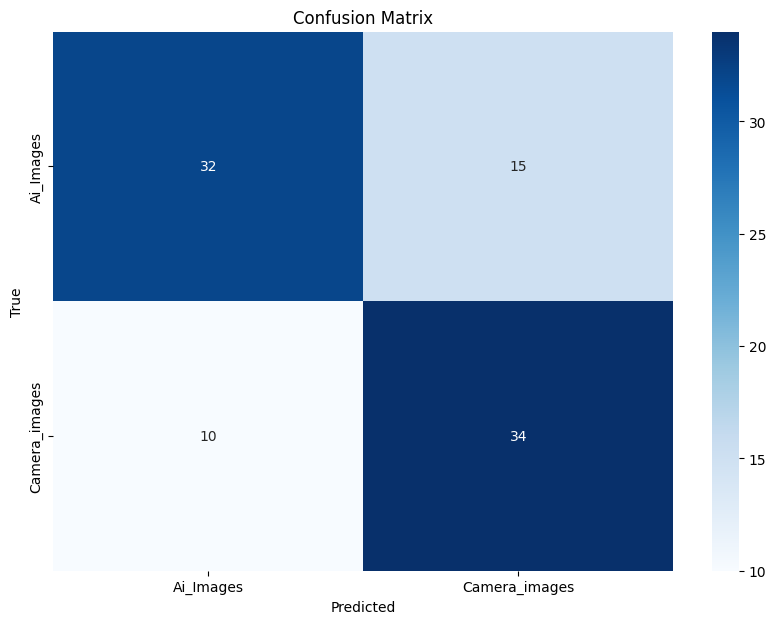

Classification Report:
               precision    recall  f1-score   support

    Ai_Images       0.76      0.68      0.72        47
Camera_images       0.69      0.77      0.73        44

     accuracy                           0.73        91
    macro avg       0.73      0.73      0.73        91
 weighted avg       0.73      0.73      0.72        91



In [22]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
cr = classification_report(all_labels, all_preds, target_names=dataset.classes)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:')
print(cr)


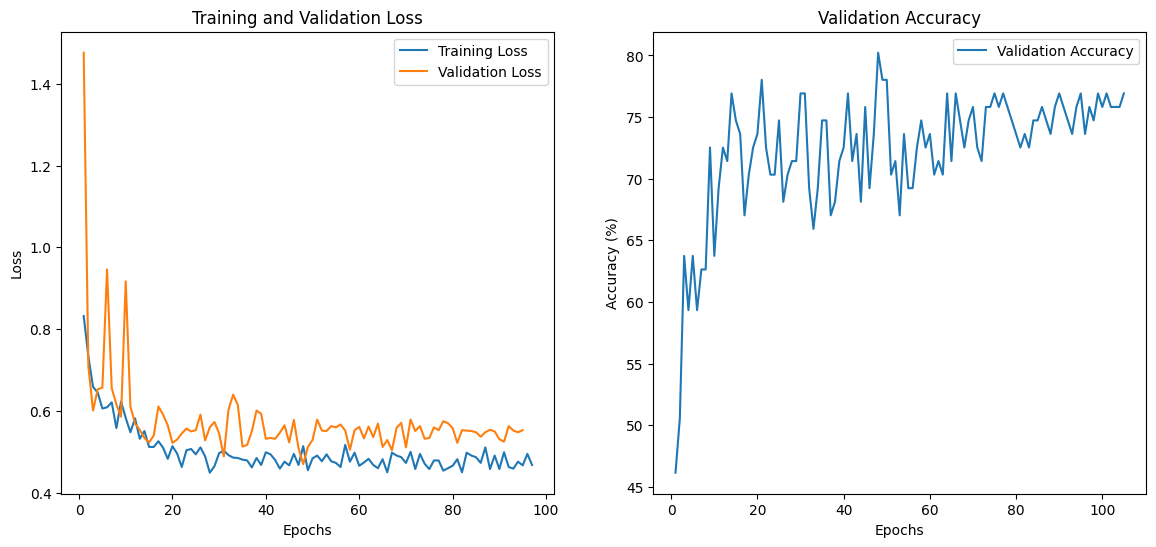

In [29]:
epochs1 = list(range(1, 98))
epochs2 = list(range(1, 96))
epochs3 = list(range(1, 106))
train_losses = [0.832, 0.733, 0.659, 0.645, 0.606, 0.609, 0.621, 0.558, 0.623, 0.583, 0.548, 0.582, 0.532, 0.551, 0.512, 0.512, 0.526, 0.510, 0.483, 0.514, 0.496, 0.463, 0.504, 0.507, 0.494, 0.511, 0.489, 0.449, 0.465, 0.497, 0.503, 0.492, 0.486, 0.485, 0.481, 0.479, 0.462, 0.485, 0.468, 0.499, 0.494, 0.480, 0.459, 0.476, 0.467, 0.495, 0.468, 0.514, 0.455, 0.484, 0.491, 0.477, 0.494, 0.477, 0.473, 0.463, 0.517, 0.476, 0.498, 0.466, 0.474, 0.483, 0.468, 0.460, 0.482, 0.450, 0.498, 0.491, 0.487, 0.473, 0.500, 0.458, 0.495, 0.471, 0.458, 0.479, 0.479, 0.454, 0.460, 0.466, 0.482, 0.450, 0.498, 0.491, 0.487, 0.473, 0.511, 0.458, 0.491, 0.458, 0.499, 0.463, 0.459, 0.476, 0.467, 0.495, 0.468]
val_losses = [1.476, 0.709, 0.601, 0.653, 0.657, 0.946, 0.656, 0.616, 0.586, 0.917, 0.611, 0.569, 0.554, 0.534, 0.523, 0.540, 0.611, 0.591, 0.565, 0.522, 0.530, 0.545, 0.557, 0.550, 0.553, 0.591, 0.528, 0.560, 0.573, 0.545, 0.489, 0.603, 0.640, 0.615, 0.513, 0.517, 0.550, 0.601, 0.593, 0.532, 0.534, 0.532, 0.547, 0.565, 0.523, 0.578, 0.509, 0.470, 0.512, 0.529, 0.579, 0.552, 0.551, 0.563, 0.560, 0.567, 0.552, 0.505, 0.553, 0.561, 0.533, 0.562, 0.536, 0.569, 0.512, 0.529, 0.504, 0.559, 0.571, 0.511, 0.579, 0.551, 0.563, 0.532, 0.534, 0.560, 0.553, 0.575, 0.570, 0.558, 0.522, 0.553, 0.552, 0.551, 0.548, 0.537, 0.548, 0.554, 0.550, 0.531, 0.525, 0.563, 0.552, 0.548, 0.553]
val_accuracies = [46.15, 50.55, 63.74, 59.34, 63.74, 59.34, 62.64, 62.64, 72.53, 63.74, 69.23, 72.53, 71.43, 76.92, 74.73, 73.63, 67.03, 70.33, 72.53, 73.63, 78.02, 72.53, 70.33, 70.33, 74.73, 68.13, 70.33, 71.43, 71.43, 76.92, 76.92, 69.23, 65.93, 69.23, 74.73, 74.73, 67.03, 68.13, 71.43, 72.53, 76.92, 71.43, 73.63, 68.13, 75.82, 69.23, 73.63, 80.22, 78.02, 78.02, 70.33, 71.43, 67.03, 73.63, 69.23, 69.23, 72.53, 74.73, 72.53, 73.63, 70.33, 71.43, 70.33, 76.92, 71.43, 76.92, 74.73, 72.53, 74.73, 75.82, 72.53, 71.43, 75.82, 75.82, 76.92, 75.82, 76.92, 75.82, 74.73, 73.63, 72.53, 73.63, 72.53, 74.73, 74.73, 75.82, 74.73, 73.63, 75.82, 76.92, 75.82, 74.73, 73.63, 75.82, 76.92, 73.63, 75.82, 74.73, 76.92, 75.82, 76.92, 75.82, 75.82, 75.82, 76.92]

# Creazione del plot
plt.figure(figsize=(14, 6))

# Plot della loss per il training e la validazione
plt.subplot(1, 2, 1)
plt.plot(epochs1, train_losses, label='Training Loss')
plt.plot(epochs2, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot della accuracy per la validazione
plt.subplot(1, 2, 2)
plt.plot(epochs3, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()